In [10]:

import pandas as pd


import os
import matplotlib.pyplot as plt

import numpy as np


import glob
from datetime import datetime


import datetime
import torch



In [3]:
hdf_raster_folder = "D:\\OneDrive\\Python\\12_pyModis\\test_data_folder\\"

rasters = [ras for ras in os.listdir(hdf_raster_folder) if ras.endswith(".hdf")]


rast = rxr.open_rasterio(hdf_raster_folder +rasters[0], masked=True).squeeze()

rast

NameError: name 'os' is not defined

In [3]:
type(rast)

xarray.core.dataset.Dataset

In [6]:
type(rast.Maximum_Snow_Extent)

xarray.core.dataarray.DataArray

In [39]:
snow_raster = rast.Maximum_Snow_Extent.values.astype("float32")

In [40]:
type(snow_raster)

numpy.ndarray

In [45]:
snow_raster_torch = torch.from_numpy(snow_raster).unsqueeze(dim = 0)

In [46]:
snow_raster_torch.shape

torch.Size([1, 2400, 2400])

In [44]:
snow_raster_torch.dtype

torch.float32

In [47]:
snow_raster_torch.min()


tensor(25.)

In [48]:
snow_raster_torch.max()

tensor(200.)

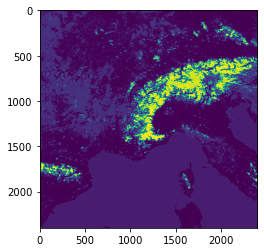

In [50]:
plt.imshow(snow_raster_torch.permute(1,2,0))

In [87]:
temp = snow_raster_torch.view(1, -1)

mean_ = temp.mean(dim=1)
std_ = temp.std(dim=1)
min_ = temp.min()
max_ = temp.max()

In [13]:
x = torch.randn(10, 5) * 10

x.shape

torch.Size([10, 5])

In [88]:
print (mean_)
print (std_)
print (min_)
print (max_)

tensor([44.9186])
tensor([42.1566])
tensor(25.)
tensor(200.)


In [89]:
snow_nomalized = (snow_raster_torch - min_)/(max_-min_)

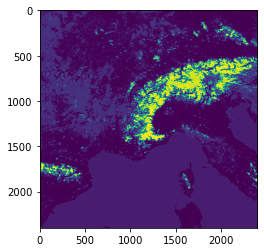

In [90]:
plt.imshow(snow_nomalized.permute(1,2,0))

In [91]:
print (snow_nomalized.max())
print (snow_nomalized.min())

tensor(1.)
tensor(0.)


In [1]:
temp = snow_raster_torch.view(1, -1)


min_ = temp.min()
max_ = temp.max()





NameError: name 'snow_raster_torch' is not defined

In [69]:
snow_nomalized

tensor([[[1.9906, 1.9906, 1.9906,  ..., 1.6585, 1.6585, 1.6585],
         [1.9906, 1.9906, 1.9906,  ..., 1.6585, 1.6585, 1.6585],
         [1.9906, 1.9906, 1.9906,  ..., 1.6585, 1.6585, 1.6585],
         ...,
         [1.6585, 1.6585, 1.6585,  ..., 1.9906, 1.9906, 1.9906],
         [1.6585, 1.6585, 1.6585,  ..., 1.9906, 1.9906, 1.9906],
         [1.6585, 1.6585, 1.6585,  ..., 1.9906, 1.9906, 1.9906]]])

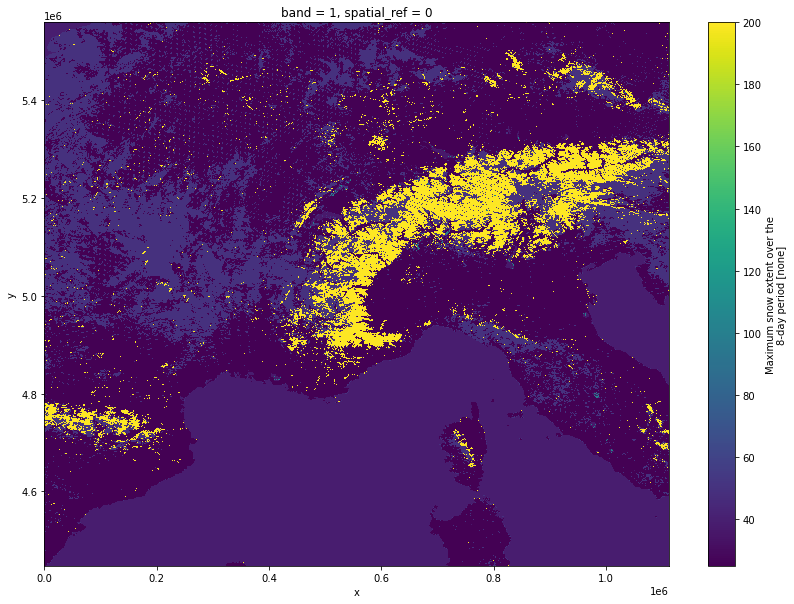

In [8]:
f, ax = plt.subplots(figsize=(14, 10))

rast.Maximum_Snow_Extent.plot.imshow()

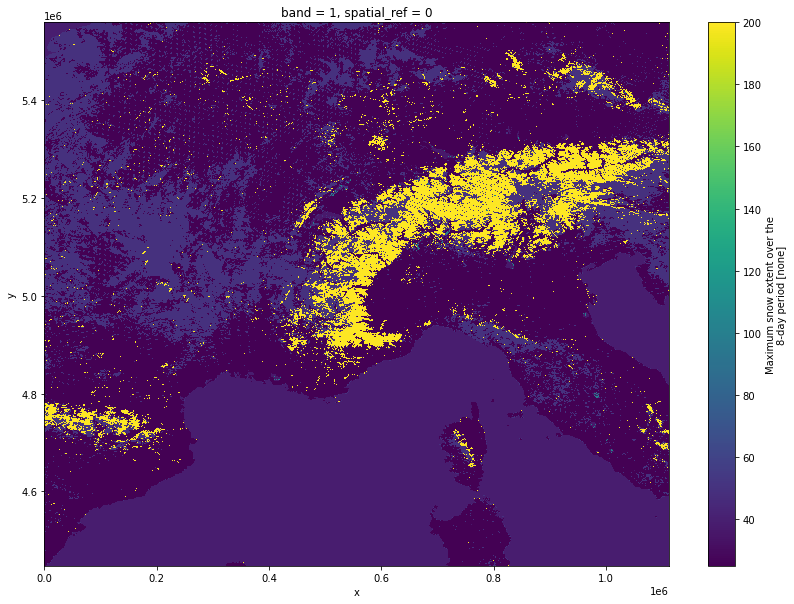

In [9]:
f, ax = plt.subplots(figsize=(14, 10))
rast.Maximum_Snow_Extent.plot.imshow()

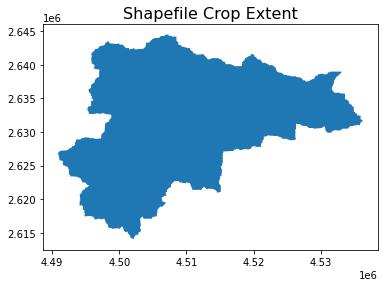

<Projected CRS: PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["E ...>
Name: ETRS89_ETRS_LAEA
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
basin = "Drava"


shape_file_name = os.path.join("basin",basin, basin + "_Basin.shp")

clip_shape =   gpd.read_file(shape_file_name)

fig, ax = plt.subplots(figsize=(6, 6))

clip_shape.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()
clip_shape.crs

In [8]:
g = gdal.Open("MOD10A2.A2000049.h18v04.006.2016064132701.hdf")

g
#subdatasets = g.GetSubDatasets()

#mysubdataset_name = subdatasets[0][0]

#snow_data = gdal.Open(mysubdataset_name, gdal.GA_ReadOnly).ReadAsArray()

In [9]:
snow_data.shape

NameError: name 'snow_data' is not defined

In [10]:
dates = pd.date_range(start="2000-01-01",end="2016-12-31")

snow_df = pd.DataFrame({"date":dates,"doy":dates.dayofyear,"snow":np.nan})
snow_df["snow"] = snow_df["snow"].astype("object")
snow_df.dtypes

date    datetime64[ns]
doy              int64
snow            object
dtype: object

In [11]:
snow_df.loc[(snow_df['doy'] == 64) & (snow_df["date"].dt.year == 2000)]

date  doy snow
63 2000-03-04   64  NaN

In [12]:
rowIndex = snow_df.index[(snow_df['doy'] == 64) & (snow_df["date"].dt.year == 2000)]

rowIndex

snow_df.loc[rowIndex, "snow"] = 34 

snow_df.head(68)

date  doy snow
0  2000-01-01    1  NaN
1  2000-01-02    2  NaN
2  2000-01-03    3  NaN
3  2000-01-04    4  NaN
4  2000-01-05    5  NaN
..        ...  ...  ...
63 2000-03-04   64   34
64 2000-03-05   65  NaN
65 2000-03-06   66  NaN
66 2000-03-07   67  NaN
67 2000-03-08   68  NaN

[68 rows x 3 columns]

In [109]:
%%time
hdf_raster_folder = "D:\\OneDrive\\Python\\12_pyModis\\data\\"
shape_file = "D:\\OneDrive\\Python\\12_pyModis\\basin\\Drava\\Drava_Basin.shp"

rasters = [ras for ras in os.listdir(hdf_raster_folder) if ras.endswith(".hdf")]

def hdf_clip(raster_folder, raster_name, shape_file):
    xds = rxr.open_rasterio(raster_folder + raster_name, masked=True, chunks=True)

    shape = gpd.read_file(shape_file, crs="epsg:4326")

    clipped = xds.rio.clip(shape.geometry.apply(mapping), shape.crs, drop=True)
    doy = int(raster_name[13:16])
    year = int(raster_name[9:13])
    
    rowIndex = snow_df.index[(snow_df['doy'] == doy) & (snow_df["date"].dt.year == year)]
    #snow_df.loc[rowIndex, "snow"]  = clipped.Maximum_Snow_Extent.values

    #print(doy, year)
    #print ("File {} hass been clipped succesfully.".format(raster_name))
    date = str(doy) + "." + str(year)
    data = clipped.Maximum_Snow_Extent.values
    return date, data
          

    
#hdf_clip(hdf_raster_folder, rasters[1:4], shape_file)

#clipps = [hdf_clip(hdf_raster_folder, raster, shape_file) for raster in rasters]

#clipps = {date:data for date, data in hdf_clip(hdf_raster_folder, raster, shape_file)}

    

          

Wall time: 2 ms


In [110]:
clipps = []

for idx, raster in enumerate(rasters):
    if idx <3:
        clipps.append(hdf_clip(hdf_raster_folder, raster, shape_file))
        
        
            
        

In [111]:
type(clipps[0])

tuple

In [114]:
for idx, (key, value) in enumerate(clipps):
    if clipps[0][idx] < 1:
        print (key)
    

TypeError: '<' not supported between instances of 'str' and 'int'

In [130]:
clipps = [x for x in hdf_clip(hdf_raster_folder, raster, shape_file)]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
clipps

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [38]:
for idx, rast in enumerate(clipps):
    print (rast)


<xarray.DataArray 'Maximum_Snow_Extent' (band: 1, y: 65, x: 97)>
dask.array<copy, shape=(1, 65, 97), dtype=float64, chunksize=(1, 65, 97), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.213e+06 5.213e+06 ... 5.184e+06 5.184e+06
  * x            (x) float64 9.315e+05 9.32e+05 9.324e+05 ... 9.755e+05 9.76e+05
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Maximum snow extent over the 8-day period
    units:         none
    grid_mapping:  spatial_ref
<xarray.DataArray 'Maximum_Snow_Extent' (band: 1, y: 65, x: 97)>
dask.array<copy, shape=(1, 65, 97), dtype=float64, chunksize=(1, 65, 97), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.213e+06 5.213e+06 ... 5.184e+06 5.184e+06
  * x            (x) float64 9.315e+05 9.32e+05 9.324e+05 ... 9.755e+05 9.76e+05
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:

In [23]:
raster_1 = clipps[1]
raster_2 = clipps[2]

In [24]:
raster_1

<xarray.DataArray 'Maximum_Snow_Extent' (band: 1, y: 65, x: 97)>
dask.array<copy, shape=(1, 65, 97), dtype=float64, chunksize=(1, 65, 97), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.213e+06 5.213e+06 ... 5.184e+06 5.184e+06
  * x            (x) float64 9.315e+05 9.32e+05 9.324e+05 ... 9.755e+05 9.76e+05
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Maximum snow extent over the 8-day period
    units:         none
    grid_mapping:  spatial_ref

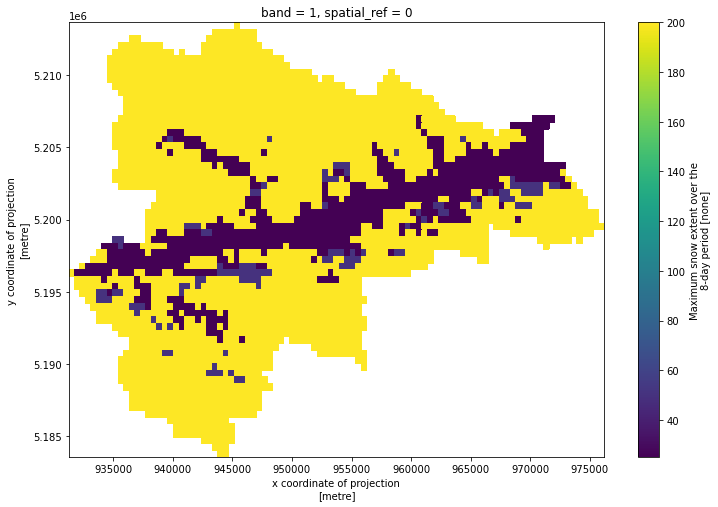

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

raster_2.plot()



In [26]:
print(raster_1)

<xarray.DataArray 'Maximum_Snow_Extent' (band: 1, y: 65, x: 97)>
dask.array<copy, shape=(1, 65, 97), dtype=float64, chunksize=(1, 65, 97), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.213e+06 5.213e+06 ... 5.184e+06 5.184e+06
  * x            (x) float64 9.315e+05 9.32e+05 9.324e+05 ... 9.755e+05 9.76e+05
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Maximum snow extent over the 8-day period
    units:         none
    grid_mapping:  spatial_ref


In [53]:
print (np.unique(snow_data))
snow_data[np.where(snow_data == 200)] = 1
snow_data[np.where(snow_data == 25)] = 2
snow_data[np.where((snow_data == 37) | (snow_data == 39))] = 3
snow_data[np.where(snow_data == 50)] = 4
snow_data[np.where(snow_data == 100)] = 5
print (np.unique(snow_data))

NameError: name 'snow_data' is not defined

In [54]:
snow_data = snow_data.where(snow_data == 200, 1)
snow_data = snow_data.where(snow_data == 25, 2) 
snow_data = snow_data.where((snow_data == 37) | (snow_data == 39), 3) 
snow_data = snow_data.where(snow_data == 50, 4) 
#snow_data = snow_data.where(snow_data == 100, 5) 




NameError: name 'snow_data' is not defined

In [ ]:
snow_data.plot()

In [3]:
snow_data = snow_data.dropna("band")

snow_data.plot()

NameError: name 'snow_data' is not defined

In [69]:
snow_data

<xarray.DataArray 'Maximum_Snow_Extent' (band: 0, y: 82, x: 114)>
dask.array<getitem, shape=(0, 82, 114), dtype=float64, chunksize=(0, 82, 114), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.244e+06 5.243e+06 ... 5.206e+06 5.206e+06
  * x            (x) float64 9.194e+05 9.199e+05 ... 9.713e+05 9.718e+05
  * band         (band) int32 
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Maximum snow extent over the 8-day period
    units:         none
    grid_mapping:  spatial_ref

In [3]:
clipps = np.load("test_snow_data.npy", allow_pickle=True)

In [4]:
clipps

array([['29.03.2000', array([[nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
                             ...,
                             [nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan]])],
       ['30.03.2000', array([[nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
                             ...,
                             [nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan]])],
       ['31.03.2000', array([[nan, nan, nan, ..., nan, nan, nan],
                             [nan, nan, nan, ..., nan, nan, nan],
  

In [7]:
clipps[0][1].shape

(65, 97)